## EXPLORING THE RELATIONSHIP BETWEEN SAT SCORES(2012) AND DEMPGRAPHIC FACTORS IN NEW YORK CITY PUBLIC SCHOOLS.

For a brief bit of background, the SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each is worth 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school, along with additional demographic datasets.source:https://data.cityofnewyork.us/browse?category=Education


* SAT scores by school  - this is the SAT scores for each high school in New York City

* School attendance - this is the Attendance information for each school in New York City

* Class size - this is the Information on class size for each school

* AP test results - this is the Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)

* Graduation outcomes - this is the percentage of students who graduated and other outcome information

* Demographics -this is the Demographic information for each school

* School survey - this are the Surveys of parents, teachers, and students at each school


New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income, and gender with SAT scores is a good way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT is unfair.

note
* Only high school students take the SAT, so we'll want to focus on high schools.

* New York City is made up of five boroughs, which are essentially distinct regions.

* New York City schools fall within several different school districts, each of which can contains dozens of schools.

* Our datasets include several different types of schools. We'll need to clean them so that we can focus on high schools only.

* Each school in New York City has a unique code called a DBN or district borough number.

* Aggregating data by district allows us to use the district mapping data to plot district-by-district differences.

### Read in the data

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [2]:
data.keys()

dict_keys(['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'sat_results'])

In [3]:
data["hs_directory"].columns

Index(['dbn', 'school_name', 'boro', 'building_code', 'phone_number',
       'fax_number', 'grade_span_min', 'grade_span_max', 'expgrade_span_min',
       'expgrade_span_max', 'bus', 'subway', 'primary_address_line_1', 'city',
       'state_code', 'zip', 'website', 'total_students', 'campus_name',
       'school_type', 'overview_paragraph', 'program_highlights',
       'language_classes', 'advancedplacement_courses', 'online_ap_courses',
       'online_language_courses', 'extracurricular_activities',
       'psal_sports_boys', 'psal_sports_girls', 'psal_sports_coed',
       'school_sports', 'partner_cbo', 'partner_hospital', 'partner_highered',
       'partner_cultural', 'partner_nonprofit', 'partner_corporate',
       'partner_financial', 'partner_other', 'addtl_info1', 'addtl_info2',
       'start_time', 'end_time', 'se_services', 'ell_programs',
       'school_accessibility_description', 'number_programs', 'priority01',
       'priority02', 'priority03', 'priority04', 'priority05', 

### Read in the surveys

In [4]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

In [5]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 55
Columns: 2773 entries, dbn to s_q14_11
dtypes: float64(2762), int64(6), object(5)
memory usage: 36.0+ MB


##### observations

* There are 2773 columns, nearly all of which we don't need. We'll have to filter the data to remove the unnecessary ones. Working with fewer columns makes it easier to print the dataframe out and find correlations within it.

* The survey data has a dbn column that we'll want to convert to uppercase (DBN). The conversion makes the column name consistent with the other data sets.

In [6]:
#since this data would be merge with other datas which have column name "DBN" that of the survey column was changed from "dbn" to "DBN"
survey["DBN"]=survey["dbn"]

survey_columns=["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

survey=survey.loc[:,survey_columns]

data["survey"]=survey

data.keys()

dict_keys(['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'sat_results', 'survey'])

### Add DBN columns

Since all the datasets would be merged using the DBN column, all the datasets must have this column.columns like class_size and hs_directory, don't have a DBN column. 

* hs_directory does have a dbn column, though, so we can just rename it.


* DBN for Class_size data is just the combination of the CSD and SCHOOL CODE columns. However the CSD column must be padded to add a leading 0 to the CSD if the CSD is less than two digits long before combining the two columns

In [7]:
data["hs_directory"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 58 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   dbn                               435 non-null    object 
 1   school_name                       435 non-null    object 
 2   boro                              435 non-null    object 
 3   building_code                     435 non-null    object 
 4   phone_number                      435 non-null    object 
 5   fax_number                        423 non-null    object 
 6   grade_span_min                    435 non-null    object 
 7   grade_span_max                    435 non-null    int64  
 8   expgrade_span_min                 33 non-null     object 
 9   expgrade_span_max                 33 non-null     float64
 10  bus                               434 non-null    object 
 11  subway                            358 non-null    object 
 12  primary_

In [8]:
data["hs_directory"]["DBN"]=data["hs_directory"]["dbn"]


def addlead0(number):
    if len(str(number))==1:
        return str(0)+str(number)
    else:
        return str(number)

data["class_size"]["padded_csd"]=data["class_size"]["CSD"].apply(addlead0)
data["class_size"]["DBN"]=data["class_size"]["padded_csd"] +data["class_size"]["SCHOOL CODE"] 

print(data["class_size"].head())

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K          CTT   
2    1       M        M015  P.S. 015 Roberto Clemente     01       GEN ED   
3    1       M        M015  P.S. 015 Roberto Clemente     01          CTT   
4    1       M        M015  P.S. 015 Roberto Clemente     02       GEN ED   

  CORE SUBJECT (MS CORE and 9-12 ONLY) CORE COURSE (MS CORE and 9-12 ONLY)  \
0                                    -                                   -   
1                                    -                                   -   
2                                    -                                   -   
3                                    -                                   -   
4                                    -                                   -   

  SERVICE CATEGORY(K-9* ONLY)  NUMBER OF STUDENTS / SEATS FILLED  \


### COMBINING THE SAT SCORE

combining the three columns that contain SAT scores -- SAT Critical Reading Avg. Score, SAT Math Avg. Score, and SAT Writing Avg. Score -- into a single column to make the scores easier to analyze.

In [9]:
# these columns are currently string objects. it must be converted to a numeric type before adding up the columns

data["sat_results"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   DBN                              478 non-null    object
 1   SCHOOL NAME                      478 non-null    object
 2   Num of SAT Test Takers           478 non-null    object
 3   SAT Critical Reading Avg. Score  478 non-null    object
 4   SAT Math Avg. Score              478 non-null    object
 5   SAT Writing Avg. Score           478 non-null    object
dtypes: object(6)
memory usage: 22.5+ KB


In [10]:
data["sat_results"]["SAT Math Avg. Score"]=pd.to_numeric(data["sat_results"]["SAT Math Avg. Score"],errors="coerce")

data["sat_results"]["SAT Critical Reading Avg. Score"]=pd.to_numeric(data["sat_results"]["SAT Critical Reading Avg. Score"],errors="coerce")

data["sat_results"]["SAT Writing Avg. Score"]=pd.to_numeric(data["sat_results"]["SAT Writing Avg. Score"],errors="coerce")

data["sat_results"]["sat_score"]=data["sat_results"][["SAT Writing Avg. Score","SAT Math Avg. Score","SAT Critical Reading Avg. Score"]].sum(axis=1)


data["sat_results"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DBN                              478 non-null    object 
 1   SCHOOL NAME                      478 non-null    object 
 2   Num of SAT Test Takers           478 non-null    object 
 3   SAT Critical Reading Avg. Score  421 non-null    float64
 4   SAT Math Avg. Score              421 non-null    float64
 5   SAT Writing Avg. Score           421 non-null    float64
 6   sat_score                        478 non-null    float64
dtypes: float64(4), object(3)
memory usage: 26.3+ KB


### Parsing Geographic coordinates for the schools

parse the latitude and longitude coordinates for each school. This enables us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field *Location 1* in the *hs_directory* dataset.

In [11]:
data["hs_directory"]["Location 1"]

0      883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...
1      1110 Boston Road\nBronx, NY 10456\n(40.8276026...
2      1501 Jerome Avenue\nBronx, NY 10452\n(40.84241...
3      411 Pearl Street\nNew York, NY 10038\n(40.7106...
4      160-20 Goethals Avenue\nJamaica, NY 11432\n(40...
                             ...                        
430    2225 Webster Avenue\nBronx, NY 10457\n(40.8546...
431    925 Astor Avenue\nBronx, NY 10469\n(40.8596983...
432    800 East Gun Hill Road\nBronx, NY 10467\n(40.8...
433    26 Broadway\nNew York, NY 10004\n(40.705234939...
434    149-11 Melbourne Avenue\nFlushing, NY 11367\n(...
Name: Location 1, Length: 435, dtype: object

In [12]:
#extracting latitude and longitude coordinates from Location 1 

def findlat(string):
    a=re.findall("\((.+)\)",string)
    b=a[0].split(",")
    return b[0]
                   

data["hs_directory"]["lat"]=data["hs_directory"]["Location 1"].apply(findlat)

data["hs_directory"]["lat"]

0       40.67029890700047
1        40.8276026690005
2      40.842414068000494
3       40.71067947100045
4      40.718810094000446
              ...        
430     40.85464659900049
431     40.85969831600045
432     40.87575421100047
433     40.70523493900049
434     40.73440841000047
Name: lat, Length: 435, dtype: object

In [13]:
def findlon(string):
    a=re.findall("\((.+)\)",string)
    b=a[0].split(",")
    return (b[1].replace(" ",""))

data["hs_directory"]["lon"]=data["hs_directory"]["Location 1"].apply(findlon)
data["hs_directory"]["lon"]

0      -73.96164787599963
1      -73.90447525699966
2      -73.91616158599965
3      -74.00080702099967
4      -73.80650045499965
              ...        
430    -73.89664555299964
431    -73.86074140399967
432    -73.86138783399963
433    -74.01331503999967
434    -73.82141748299966
Name: lon, Length: 435, dtype: object

In [14]:
data["hs_directory"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 61 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   dbn                               435 non-null    object 
 1   school_name                       435 non-null    object 
 2   boro                              435 non-null    object 
 3   building_code                     435 non-null    object 
 4   phone_number                      435 non-null    object 
 5   fax_number                        423 non-null    object 
 6   grade_span_min                    435 non-null    object 
 7   grade_span_max                    435 non-null    int64  
 8   expgrade_span_min                 33 non-null     object 
 9   expgrade_span_max                 33 non-null     float64
 10  bus                               434 non-null    object 
 11  subway                            358 non-null    object 
 12  primary_

 ##### converting the latitude and longitude to numeric values. We can use the pandas.to_numeric() function to convert them from strings to numbers.

In [15]:
data["hs_directory"]["lon"]=pd.to_numeric(data["hs_directory"]["lon"],errors="coerce")

data["hs_directory"]["lat"]=pd.to_numeric(data["hs_directory"]["lat"],errors="coerce")

In [16]:
data["hs_directory"]["lon"].dtype

dtype('float64')

In [17]:
data["hs_directory"]["lat"].dtype

dtype('float64')

### GROUPING 

class_size, graduation and demographics datasets dont have a unique DBN . This would cause issues when we merge all the datasets together.

* class size dataset
  schools has multiple values for GRADE, PROGRAM TYPE, CORE SUBJECT (MS CORE and 9-12 ONLY), and CORE COURSE (MS CORE and 9-12   ONLY),hence the multiple DBN.
  1)Grade
   we're only concerned with grades 9 through 12. That means we only want to pick rows where the     value in the GRADE            column is 09-12.
  
  2)program type
  Each school can have multiple program types. Since GEN ED is the largest category by far, let's only select rows where         PROGRAM TYPE is GEN ED.
  
  3)CORE COURSE (MS CORE and 9-12 ONLY) and CORE SUBJECT (MS CORE and 9-12 ONLY).This column only seems to include certain         subjects. We want our class size data to include every single class a school offers -- not just a subset of them. What we       can do is take the average across all of the classes a school offers. This gives us unique DBN values, while also 
    incorporating as much data as possible into the average.
    
  
* Demographics dataset

   In this dataset, the only column that prevents a given DBN from being unique is schoolyear. We only want to select rows        where schoolyear is 20112012. This will give us the most recent year of data, and also match our SAT results data.
   
  
* Graduation dataset

    the Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer     to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we         want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll       only pick rows where Demographic is Total Cohort.

In [18]:
class_size=data["class_size"]

filterbool1=class_size["GRADE "]=="09-12"

class_size=class_size.loc[filterbool1]

filterbool2=class_size["PROGRAM TYPE"]=="GEN ED"

class_size=class_size.loc[filterbool2]

class_size

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27604,32,K,K564,Bushwick Community High School,09-12,GEN ED,SCIENCE,Physics,-,49.0,2.0,24.5,22.0,27.0,STARS,NaN,32,32K564
27605,32,K,K564,Bushwick Community High School,09-12,GEN ED,SOCIAL STUDIES,Global History & Geography,-,237.0,10.0,23.7,15.0,31.0,STARS,NaN,32,32K564
27606,32,K,K564,Bushwick Community High School,09-12,GEN ED,SOCIAL STUDIES,US History & Government,-,256.0,10.0,25.6,15.0,35.0,STARS,NaN,32,32K564
27607,32,K,K564,Bushwick Community High School,09-12,GEN ED,SOCIAL STUDIES,Economics,-,65.0,2.0,32.5,32.0,33.0,STARS,NaN,32,32K564


In [19]:
class_size=class_size.groupby("DBN").mean()

class_size.reset_index(inplace=True)

data["class_size"]=class_size

data["class_size"]["DBN"].value_counts()

16K498    1
07X670    1
27Q410    1
13K483    1
21K238    1
         ..
19K504    1
07X655    1
10X438    1
22K495    1
20K445    1
Name: DBN, Length: 583, dtype: int64

In [20]:
data["demographics"]=data["demographics"].loc[data["demographics"]["schoolyear"]==20112012]

In [21]:
filterb=(data["graduation"]["Cohort"]=="2006")& (data["graduation"]["Demographic"]=="Total Cohort")

data["graduation"]=data["graduation"].loc[filterb]

### Converting AP test Scores

The last thing to do is convert the Advanced Placement (AP) test scores from strings to numeric values. High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.

AP exams have a 1 to 5 scale; 3 or higher is a passing score. Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are rarer in schools that lack funding or academic rigor.

In [22]:
data["ap_2010"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   DBN                                   258 non-null    object
 1   SchoolName                            258 non-null    object
 2   AP Test Takers                        258 non-null    object
 3   Total Exams Taken                     258 non-null    object
 4   Number of Exams with scores 3 4 or 5  258 non-null    object
dtypes: object(5)
memory usage: 10.2+ KB


There are three columns we'll need to convert:

* AP Test Takers (note that there's a trailing space in the column name)
* Total Exams Taken
* Number of Exams with scores 3 4 or 5

In [23]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']


for name in cols:
    data["ap_2010"][name] =pd.to_numeric(data["ap_2010"][name],errors="coerce")
    
data["ap_2010"].dtypes


DBN                                      object
SchoolName                               object
AP Test Takers                          float64
Total Exams Taken                       float64
Number of Exams with scores 3 4 or 5    float64
dtype: object

### COMBINING 7 ALL THE DATASETS IN DATA

note

1) Both the ap_2010 and the graduation datasets have many missing DBN values, so we'll use a left join when we merge the sat_results data set with them.

2) class_size, demographics, survey, and hs_directory contain information that's more valuable to our analysis and also have fewer missing DBN values, we'll use the inner join type.


In [24]:
data.keys()

dict_keys(['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'sat_results', 'survey'])

In [25]:
combined = data["sat_results"]

combined=pd.merge(combined,data["ap_2010"],on="DBN",how="left")

combined=combined.merge(data["graduation"],on="DBN",how="left")

cols=["class_size","demographics","survey","hs_directory"]

for c in cols:
    combined=combined.merge(data[c],on="DBN",how="inner")
    
combined.shape

(363, 159)

### Filling Nan Values

1) notice that we now have many columns with null (NaN) values. This is because we chose to do left joins, where some columns may not have had data. The dataset also had some missing values to begin with. If we hadn't performed a left join, all of the rows with missing data would have been lost in the merge process, which wouldn't have left us with many high schools in our data set.

2) filling in the missing values with the overall mean for the column

3) Note that if a column consists entirely of null or NaN values, pandas won't be able to fill in the missing values when we      use the df.fillna() method along with the df.mean() method, because there won't be a mean.

   We should fill any NaN or null values that remain after the initial replacement with the value 0. We can do this by passing    0 into the df.fillna() method.

In [26]:
meanofeachcolumn=combined.mean()

combined=combined.fillna(meanofeachcolumn)

combined=combined.fillna(0)


In [27]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 363 entries, 0 to 362
Columns: 159 entries, DBN to lon
dtypes: float64(55), int64(12), object(92)
memory usage: 453.8+ KB


### Add a school district column for mapping

note The school district is just the first two characters of the DBN

In [28]:
def districtcode(DBNcodestring):
    return DBNcodestring[0:2]

combined["school_dist"]=combined["DBN"].apply(lambda DBNcodestring:DBNcodestring[0:2])

combined["school_dist"]

0      01
1      01
2      01
3      01
4      01
       ..
358    32
359    32
360    32
361    32
362    32
Name: school_dist, Length: 363, dtype: object

### Finding correlations

The first thing we'll do is find any correlations between columns and sat_score. This helps us determine which columns might be interesting to plot out or investigate further.

In [29]:
correlations=combined.corr()
correlations

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
SAT Critical Reading Avg. Score,1.000000,0.929221,0.982826,0.472399,0.490283,0.483479,0.441813,0.289710,0.035699,0.357418,...,NaN,NaN,-0.064120,0.367945,0.111556,NaN,NaN,NaN,-0.119993,-0.126479
SAT Math Avg. Score,0.929221,1.000000,0.931385,0.465612,0.545646,0.533239,0.469456,0.379012,0.078078,0.444985,...,NaN,NaN,-0.033971,0.460646,0.134403,NaN,NaN,NaN,-0.134572,-0.120055
SAT Writing Avg. Score,0.982826,0.931385,1.000000,0.472854,0.501648,0.495321,0.451790,0.282701,0.009161,0.353928,...,NaN,NaN,-0.093174,0.366308,0.096834,NaN,NaN,NaN,-0.100551,-0.143850
sat_score,0.472399,0.465612,0.472854,1.000000,0.254925,0.250432,0.221759,0.161070,0.080944,0.305352,...,NaN,NaN,0.024594,0.291860,0.182280,NaN,NaN,NaN,-0.080811,-0.048274
AP Test Takers,0.490283,0.545646,0.501648,0.254925,1.000000,0.992192,0.901513,0.602802,0.091956,0.699954,...,NaN,NaN,0.066540,0.677453,0.178590,NaN,NaN,NaN,-0.104464,-0.053121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
priority08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
priority09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
priority10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,-0.119993,-0.134572,-0.100551,-0.080811,-0.104464,-0.092747,-0.049501,-0.173088,-0.530901,-0.169959,...,NaN,NaN,-0.554974,-0.196901,-0.229880,NaN,NaN,NaN,1.000000,0.280425


In [30]:
correlations["sat_score"]

SAT Critical Reading Avg. Score    0.472399
SAT Math Avg. Score                0.465612
SAT Writing Avg. Score             0.472854
sat_score                          1.000000
AP Test Takers                     0.254925
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.080811
lon                               -0.048274
Name: sat_score, Length: 67, dtype: float64

In [31]:
correlations=correlations["sat_score"]

#### observations

* total_enrollment has a strong positive correlation with sat_score. This is surprising because we'd expect smaller schools where students receive more attention to have higher scores. However, it looks like the opposite is true -- larger schools tend to do better on the SAT.

* Other columns that are proxies for enrollment correlate similarly. These include total_students, N_s, N_p, N_t, AP Test Takers, Total Exams Taken, and NUMBER OF SECTIONS.


* Both the percentage of females (female_per) and number of females (female_num) at a school correlate positively with SAT score, whereas the percentage of males (male_per) and the number of males (male_num) correlate negatively. This could indicate that women do better on the SAT than men.


* Teacher and student ratings of school safety (saf_t_11, and saf_s_11) correlate with sat_score.

* Student ratings of school academic standards (aca_s_11) correlate with sat_score, but this does not hold for ratings from teachers and parents (aca_p_11 and aca_t_11).


* There is significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).

* The percentage of English language learners at the school (ell_percent, frl_percent) has a strong negative correlation with SAT scores.

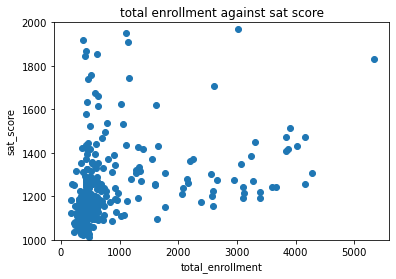

In [32]:
import matplotlib.pyplot as plt

plt.scatter(combined["total_enrollment"],combined["sat_score"])
plt.xlabel("total_enrollment")
plt.ylabel("sat_score")
plt.title("total enrollment against sat score")
plt.ylim([1000,2000])
plt.show()

#import matplotlib.pyplot as plt
#combined.plot.scatter(x='total_enrollment', y='sat_score')
#plt.show()

##### observation

judging from the plot we just created, it doesn't appear there's a strong correlation between sat_score and total_enrollment. If there was a strong correlation, we'd expect all of the points to line up. Instead, there's a large cluster of schools and then a few others going off in three different directions.

However, there's an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. This cluster may be what's making the r value so high. It's worth extracting the names of the schools in this cluster so we can research them further.

In [33]:
low_enrollment=combined.loc[(combined["total_enrollment"]<1000)& (combined["sat_score"]<1000)]

print(low_enrollment["School Name"][low_enrollment["School Name"]!=0])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
197                      FOUNDATIONS ACADEMY
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


Our research  revealed that most of the high schools with low total enrollment and low SAT scores have high percentages of English language learners. This indicates that it's actually ell_percent that correlates strongly with sat_score, rather than total_enrollment

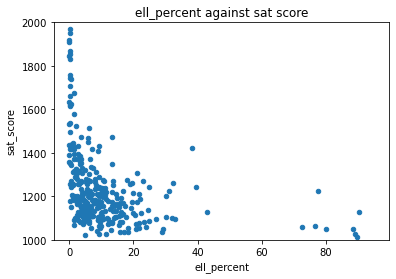

In [34]:

combined.plot(x="ell_percent",y="sat_score",kind="scatter")

plt.xlabel("ell_percent")
plt.ylabel("sat_score")
plt.title("ell_percent against sat score")
plt.ylim(1000,2000)
plt.show()

### Calculating District Level Statictics

In [35]:
districts=combined.groupby("school_dist").agg(np.mean)

districts.reset_index("school_dist",inplace=True)

print(districts.head(1))

  school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0          01                       441.833333           473.333333   

   SAT Writing Avg. Score  sat_score  AP Test Takers   Total Exams Taken  \
0              439.333333     1354.5        116.68109         173.019231   

   Number of Exams with scores 3 4 or 5  Total Cohort  CSD  ...  \
0                                 135.8          93.5  1.0  ...   

   grade_span_max  expgrade_span_max           zip  total_students  \
0            12.0               12.0  10003.166667           659.5   

   number_programs  priority08  priority09  priority10        lat        lon  
0         1.333333         0.0         0.0         0.0  40.719022 -73.982377  

[1 rows x 68 columns]


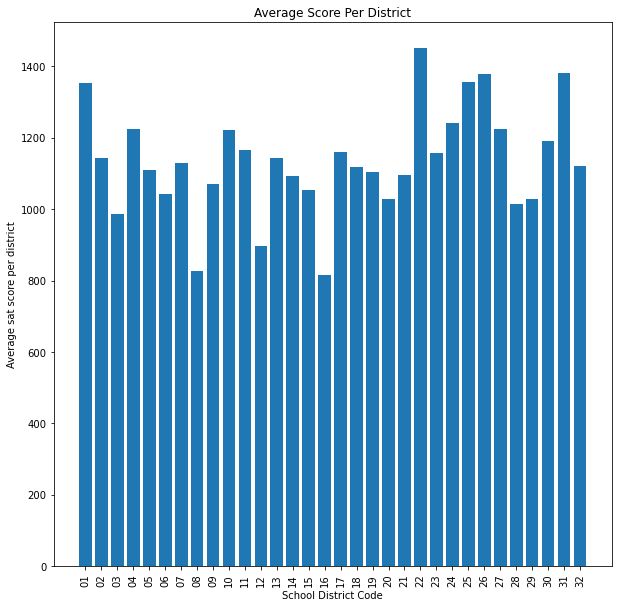

In [36]:
plt.figure(figsize=(10,10))
plt.bar(districts["school_dist"],districts["sat_score"])
plt.ylabel("Average sat score per district")
plt.xlabel("School District Code")
plt.xticks(rotation=90)
plt.title("Average Score Per District")

plt.show()

### Stacked bar chat

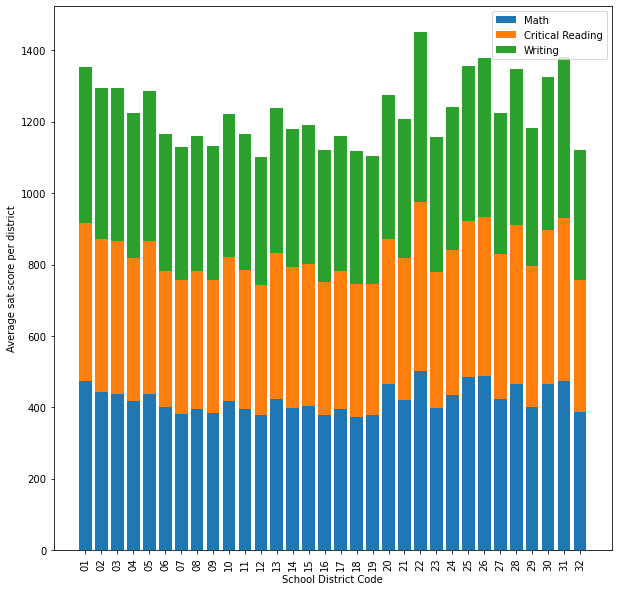

In [37]:
plt.figure(figsize=(10,10))
plt.bar(districts["school_dist"],districts["SAT Math Avg. Score"],0.8,label="Math")
plt.bar(districts["school_dist"],districts["SAT Critical Reading Avg. Score"],0.8,bottom=districts["SAT Math Avg. Score"],label="Critical Reading")
plt.bar(districts["school_dist"],districts["SAT Writing Avg. Score"],0.8,bottom=districts["SAT Math Avg. Score"]+districts["SAT Critical Reading Avg. Score"],label="Writing")
plt.xlabel("School District Code")
plt.ylabel("Average sat score per district")
plt.xticks(rotation=90)
plt.legend(loc =1)
plt.show()


### Survey and SAT score correlation

There are several fields in combined that originally came from a survey of parents, teachers, and students. Make a bar plot of the correlations between these fields and sat_score.

link to survey dictionary to aid in understanding the survey column names:https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8

In [38]:
data["survey"].keys()

Index(['DBN', 'rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11',
       'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11',
       'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11',
       'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11'],
      dtype='object')

In [39]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)

In [40]:
survey_columns

['DBN',
 'rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

In [41]:
#series for correlations between sat_score and all the other columns
series=combined.corr()["sat_score"]
series

SAT Critical Reading Avg. Score    0.472399
SAT Math Avg. Score                0.465612
SAT Writing Avg. Score             0.472854
sat_score                          1.000000
AP Test Takers                     0.254925
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.080811
lon                               -0.048274
Name: sat_score, Length: 67, dtype: float64

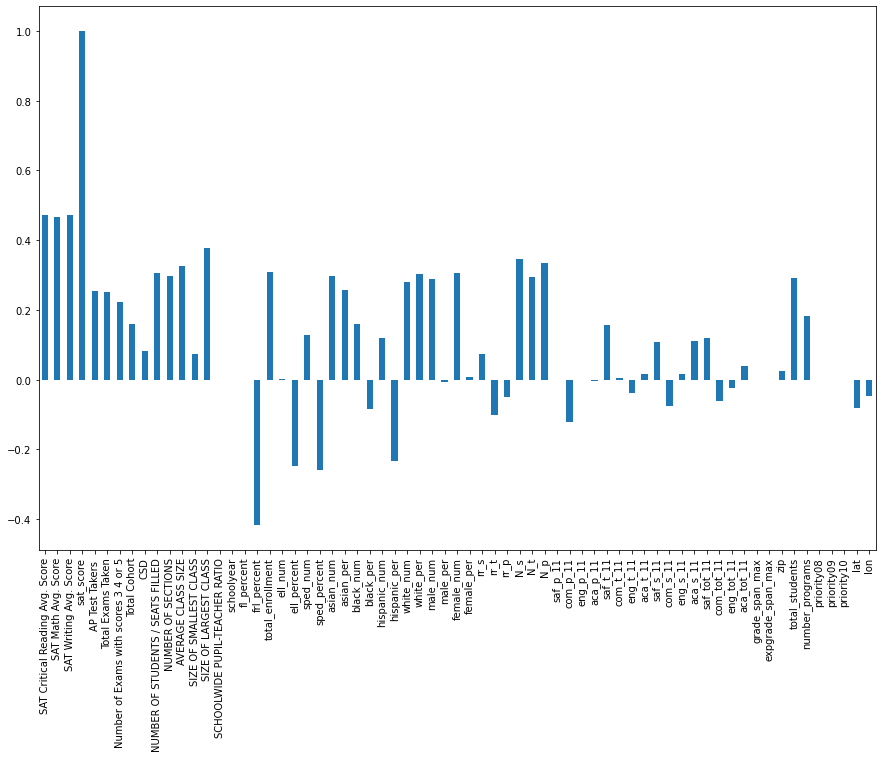

In [42]:
plt.figure(figsize=(15,10))
series.plot(kind="bar")
plt.show()

In [43]:
# for all sujrvey_columns
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_columns.remove("DBN")

Text(0, 0.5, 'correlation with SAT scores')

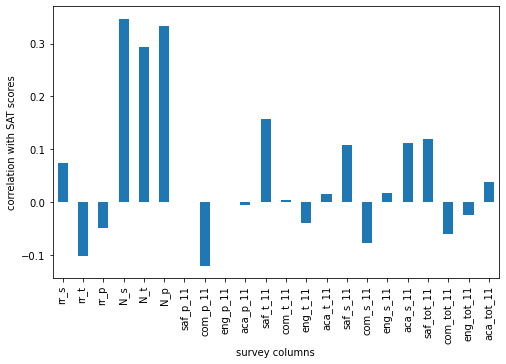

In [44]:
plt.figure(figsize=(8,5))
series[survey_columns].plot(kind="bar")
plt.xlabel("survey columns")
plt.ylabel("correlation with SAT scores")

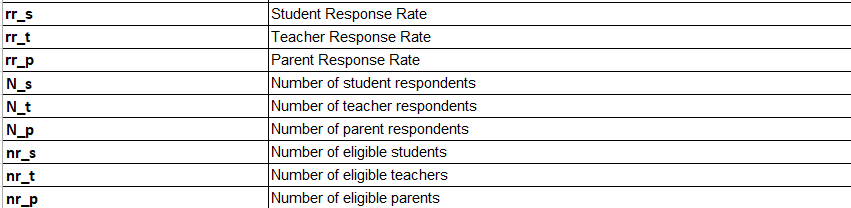
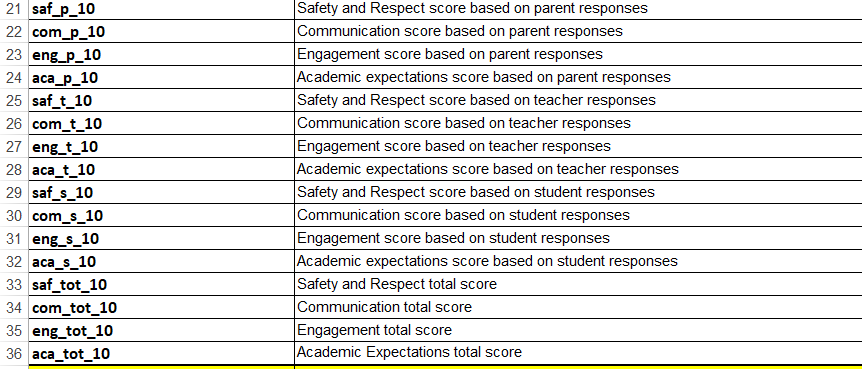

In [45]:
a=series.index[-32:-10]

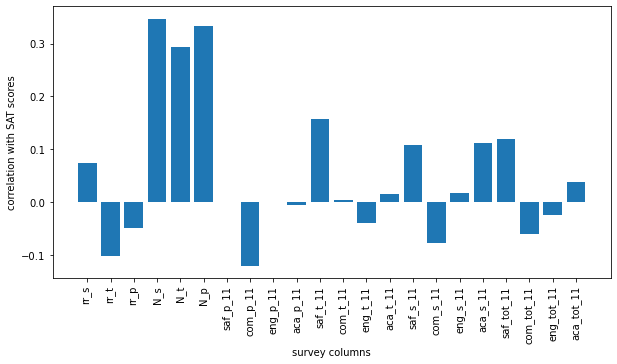

In [46]:
plt.figure(figsize=(10,5))
plt.bar(a,series[survey_columns])

plt.xlabel("survey columns")
plt.ylabel("correlation with SAT scores")
plt.xticks(rotation=90)
plt.show()

#### observations

*Genrally a relatively weaker positive and negative correlation of not more than 0.35 and -0.15 respectively

*There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

* It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

* How students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

* The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

### Exploring Safety

(saf_t_11(0.18) and saf_s_11 (0.13)) correlate with sat_score 

it still relatively a weak correlation

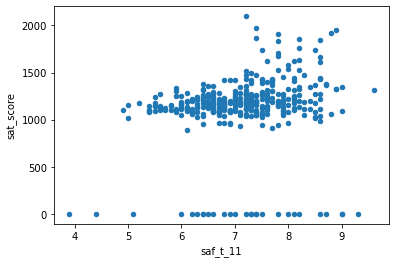

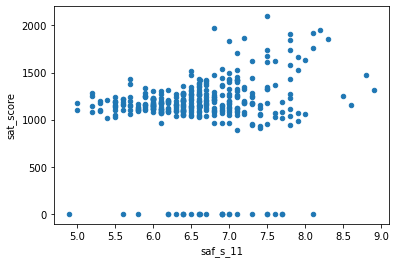

In [47]:
combined.plot.scatter("saf_t_11","sat_score")
combined.plot.scatter("saf_s_11","sat_score")
plt.show()

seems schools with sat_score of 0 are affecting our correlation and charts. Intresting to see that some of the schools witha sat_score of zero still has high recording for safety.

is possible these sat scores arent zero but were just not recorded.

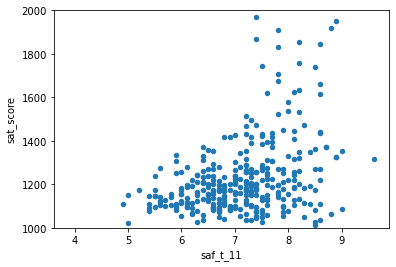

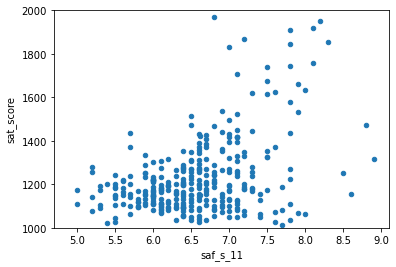

In [48]:
#focusing on sat score above 1000
combined.plot.scatter("saf_t_11","sat_score")
plt.ylim(1000,2000)
combined.plot.scatter("saf_s_11","sat_score")
plt.ylim(1000,2000)
plt.show()

#### observations

There appears to be a correlation between SAT scores and safety, although it isn't thatstrong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

In [49]:
# focusing all schools with sat scores greater than zero
satscore_zero=combined.loc[combined["sat_score"]==0]
satscore_zero["sat_score"].value_counts(ascending=True)


0.0    28
Name: sat_score, dtype: int64

In [50]:
satscore_nonzero=combined.loc[combined["sat_score"]!=0]
satscore_nonzero["sat_score"].value_counts(ascending=True)

1473.0    1
1969.0    1
1134.0    1
1290.0    1
1155.0    1
         ..
1127.0    3
1077.0    3
1122.0    3
1169.0    4
1111.0    4
Name: sat_score, Length: 243, dtype: int64

In [51]:
satscore_nonzero.corr()["sat_score"]

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523318
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.124166
lon                               -0.137163
Name: sat_score, Length: 67, dtype: float64

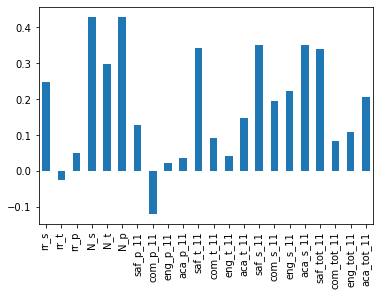

In [52]:
satscore_nonzero.corr()["sat_score"][survey_columns].plot(kind="bar")

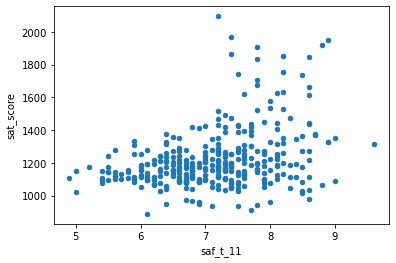

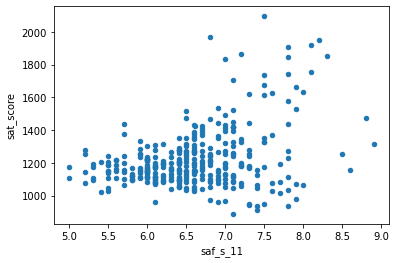

In [53]:
satscore_nonzero.plot.scatter("saf_t_11","sat_score")
satscore_nonzero.plot.scatter("saf_s_11","sat_score")
plt.show()

#### observations

safety correlations for schools with SAT scores greater than zero are more correlated to sat_score (however is still relatively a weak correlation of not more than 0.45). Most of the measures are now more positvely correlated.

##### Borough safety

information on boroughs in new york:https://www.nycgo.com/boroughs-neighborhoods/

In [54]:
combined["boro"].value_counts()

Brooklyn         106
Bronx             93
Manhattan         90
Queens            64
Staten Island     10
Name: boro, dtype: int64

In [55]:
#columns relating to saftey
survey_columns

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

In [56]:
borough_safety=combined.groupby("boro").mean()[survey_columns]
borough_safety

,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,aca_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
boro,,,,,,,,,,,,,,,,,,,,,
Bronx,80.440860,80.784946,42.440860,435.959229,30.559140,202.333333,8.346237,7.805376,7.639785,7.947312,...,6.884946,7.427957,6.606577,6.093492,6.630326,7.418079,7.322581,6.765591,7.046237,7.598925
Brooklyn,77.952830,82.122642,34.783019,575.726415,39.179245,249.754717,8.036792,7.600000,7.516981,7.789623,...,6.979245,7.497170,6.370755,6.028302,6.549057,7.313208,7.129245,6.715094,7.016038,7.535849
Manhattan,83.322222,85.211111,39.900000,495.615741,31.566667,203.255556,8.288889,7.577778,7.465556,7.786667,...,6.963333,7.472222,6.831370,6.179883,6.644895,7.408475,7.473333,6.728889,7.021111,7.556667
Queens,82.000000,84.796875,38.718750,878.234375,57.046875,318.843750,8.098437,7.476563,7.425000,7.685937,...,7.139063,7.668750,6.721875,6.090625,6.664063,7.410938,7.387500,6.779687,7.073438,7.593750
Staten Island,88.900000,91.300000,43.500000,1476.600000,88.900000,593.300000,7.800000,7.390000,7.460000,7.620000,...,7.390000,7.860000,6.530000,6.070000,6.780000,7.330000,7.200000,6.870000,7.200000,7.610000


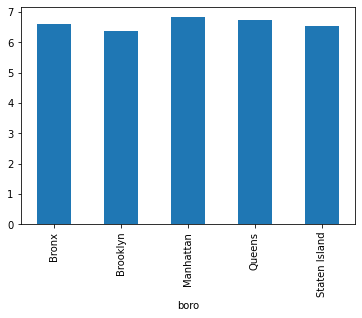

In [57]:
borough_safety["saf_s_11"].plot(kind="bar")

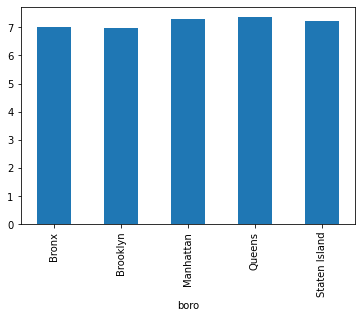

In [58]:
borough_safety["saf_t_11"].plot(kind="bar")

#### observation

relatively the same level of safety.
It looks like Manhattan and Queens tend to have higher safety scores, whereas Brooklyn has low teacher and student safety scores

### RACIAL DIFFERENCE IN SAT SCORES

In [59]:
racial_columns=["white_per","asian_per","black_per","hispanic_per"]

In [60]:
combined[racial_columns]

,white_per,asian_per,black_per,hispanic_per
0,1.7,14.0,29.1,53.8
1,2.3,29.2,22.6,45.9
2,10.4,9.7,23.9,55.4
3,1.6,9.3,31.6,56.9
4,44.9,27.8,11.7,14.2
...,...,...,...,...
358,0.7,1.7,9.2,88.1
359,1.8,0.5,28.3,68.7
360,1.0,1.5,26.4,70.4
361,1.5,5.3,12.9,79.5


In [61]:
#correlation of sat scores for only racial columns
racial_correlation=combined.corr()["sat_score"][racial_columns]
racial_correlation

white_per       0.302345
asian_per       0.256366
black_per      -0.085260
hispanic_per   -0.233828
Name: sat_score, dtype: float64

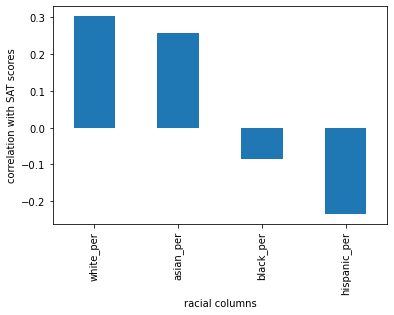

In [62]:
racial_correlation.plot.bar()
plt.xlabel("racial columns")
plt.ylabel("correlation with SAT scores")
plt.show()

#### observation
It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.



(1000.0, 2000.0)

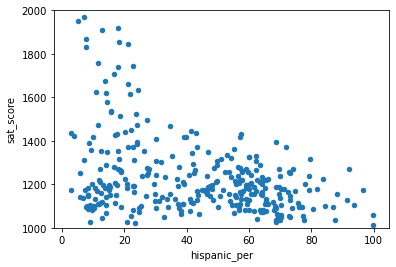

In [63]:
combined.plot.scatter("hispanic_per", "sat_score")
plt.ylim(1000,2000)

Surprisingly school with a percentage of below 20% hispanic student tend to score high sat_scores than those with higher percentages. Generally most hispanic student have sat_scores below 1400

In [64]:
#Researching any schools with a hispanic_per greater than 95%

condition95=combined["hispanic_per"]>95

combined.loc[condition95,"school_name"]



44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object

The schools listed above seems to be related to fresh immigrants in the US. Maybe it would explain the lower SAT scores.

In [65]:
# sat_score is the average sat_ score as it was acquired by combining the average math,critical reading and writing scores

#Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.

condition10satscore1800=(combined["hispanic_per"]<10)&(combined["sat_score"]>1800)
combined.loc[condition10satscore1800,"school_name"]

37                                Stuyvesant High School
151                         Bronx High School of Science
187                       Brooklyn Technical High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object

The schools listed above appear to be specialized science and technology schools, which means: receiving extra funding, and only admit students who pass an entrance exam. It can explain why their students tend to do better on the SAT - they are students from all over New York City who did well on a standardized test.

### Gender differences in SAT scores

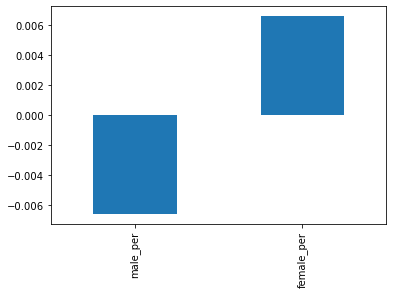

In [66]:
gender=["male_per","female_per"]
combined.corr()["sat_score"][gender].plot(kind="bar")

From the output, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. It's good to keep in mind that the difference isn't much.

(1000.0, 2000.0)

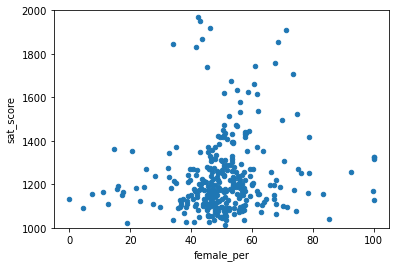

In [67]:
combined.plot.scatter("female_per", "sat_score")
plt.ylim(1000,2000)

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [69]:
# Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.

condition60satscore1700=(combined["female_per"]>60)&(combined["sat_score"]>1700)
combined.loc[condition60satscore1700,"school_name"]


5                         Bard High School Early College
26                         Eleanor Roosevelt High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
302                          Townsend Harris High School
Name: school_name, dtype: object

These schools appears to be very selective liberal arts schools that have high academic standards.

### AP Exam Scores vs SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

In [76]:
combined[['AP Test Takers ',"total_enrollment"]]

,AP Test Takers,total_enrollment
0,129.028846,422
1,39.000000,394
2,19.000000,598
3,129.028846,367
4,255.000000,1613
...,...,...
358,47.000000,606
359,129.028846,434
360,76.000000,398
361,7.000000,263


In [77]:
combined["ap_per"]=combined['AP Test Takers ']/ combined["total_enrollment"]

In [78]:
combined["ap_per"]

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
         ...   
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 363, dtype: float64

(1000.0, 2000.0)

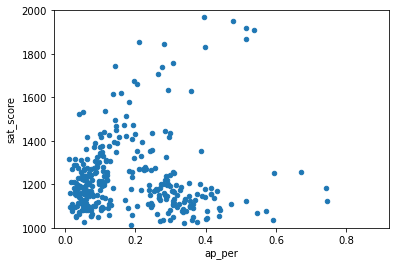

In [79]:
combined.plot.scatter("ap_per", "sat_score")
plt.ylim(1000,2000)

It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

###  Summarizing the main insights

1. The above analysis shows that larger schools tend to have students who do better on the SAT. What's more, women do better on the SAT than men.

2. We can point out that safety and respect perceptions seem to be important in achieving higher SAT scores.

3. A higher percentage of white and Asian students at a school correlates positively with the sat score, whereas a higher percentage of black and Hispanic students correlates negatively with the SAT score. Possible reasons:

* a lack of funding for schools in certain areas.

* more poor sub-boroughs and people who live there.